In [1]:
import random

import torch
import torch.nn as nn
import torch.optim as optim

We have inputs to an Artificial Neural Network like these:

In [2]:
input = torch.tensor([
  [0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0],
  [1, 1, 1, 1, 1]
], dtype=torch.float)

They represent some geometric objects. In this case it's a line.

The receptive field in our ANN will be bigger than this input. Every input is randomly moved.

So next, we take the input and create K=5 displacements (moving the original tensor in receptive field by (x,y) offset).

In [3]:
K = 5
N = 15

In [4]:
def create_displaced_tensors(tensor, K, receptive_field_size=(15, 15)):
    """
    Creates K displacements of the input tensor by moving it within a larger receptive field.
    
    Parameters:
        tensor (torch.Tensor): The original input tensor of shape (5, 5).
        K (int): The number of displacements to create.
        receptive_field_size (tuple): The dimensions of the receptive field (height, width).
        
    Returns:
        batch of tensors: A tensor of K tensors with the original tensor displaced within the receptive field.
    """
    
    # Create a larger tensor filled with zeros (the receptive field)
    receptive_field_h, receptive_field_w = receptive_field_size
    displaced_tensors = torch.zeros(K, receptive_field_h, receptive_field_w, dtype=tensor.dtype)
    
    # Calculate padding size based on the receptive field dimensions
    input_h, input_w = tensor.shape
    padding_h = receptive_field_h - input_h
    padding_w = receptive_field_w - input_w
    
    for i in range(K):
        # Randomly choose top-left corner for placing the input tensor within the receptive field
        max_x_offset = padding_h
        max_y_offset = padding_w
        x_offset = random.randint(0, max_x_offset)
        y_offset = random.randint(0, max_y_offset)
        
        # Place the input tensor within the receptive field at the chosen offset
        displaced_tensors[i, x_offset:x_offset + input_h, y_offset:y_offset + input_w] = tensor

    return displaced_tensors

input_saccades = create_displaced_tensors(input,
                                          K=K,
                                          receptive_field_size=(N, N))

In [5]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

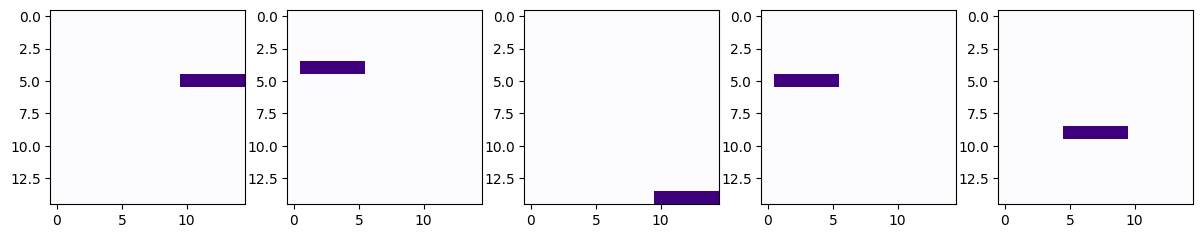

In [6]:
fig, axs = plt.subplots(1, K, figsize=(12, 4))
for i in range(K):
  axs[i].imshow(input_saccades[i].detach().numpy(), cmap=cm.Purples)

plt.tight_layout()
plt.show()


Purpose of the first step is to make transformations absolutely unlinked from the coordinates. We will be building a hierarchical network that will generalize the concept.

In this configuration we cannot use any output tensors or labels and therefore an error function cannot be used for backpropagation in weight adjustment. 

So, how to make a hierarchical network (not CNN) and group these different representation of lines into one latent feature activated on the last layer?

In [7]:
class HierarchicalNetwork(nn.Module):
    def __init__(self):
        super(HierarchicalNetwork, self).__init__()
        # Define hierarchical layers to capture line patterns without spatial dependence
        self.layer1 = nn.Linear(N*N, 32)  # Input flattened from receptive field (7x7)
        self.layer2 = nn.Linear(32, 16)  # Reduced dimensional layer
        self.layer3 = nn.Linear(16, 8)   # Latent feature layer

    def forward(self, x):
        x = x.flatten()
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        latent_feature = torch.sigmoid(self.layer3(x))  # Latent feature activation
        return latent_feature


model = HierarchicalNetwork()

Adjust weights for each connection using Oja’s rule:
   
$
\Delta w_{ij} = \eta \cdot y_i (x_j - y_i \cdot w_{ij})
$

where:

- $w_{ij}$ is the weight between neuron $j$ in the previous layer and neuron $i$ in the current layer.
- $\eta$ is the learning rate.
- $x_j$ is the activation from the previous layer.
- $y_i$ is the activation of the current neuron after applying the current weights.

In [48]:
class OjasHierarchicalNetwork(nn.Module):
    def __init__(self, input_dim=N*N, hidden_dims=[36, 16, 8], learning_rate=0.01):
        super(OjasHierarchicalNetwork, self).__init__()

        dims = zip([input_dim] + hidden_dims[:-1], hidden_dims)
        self.layers = nn.ModuleList([nn.Linear(in_dim, out_dim) for in_dim, out_dim in dims])
        self.eta = learning_rate

    def forward(self, x):
        x = x.flatten()
        activations = [x]
        for layer in self.layers:
            x = torch.relu(layer(x))
            activations.append(x)
        return activations

    def oja_update(self, activations):
        for i in range(len(activations) - 1):
            layer = self.layers[i]
            weight = layer.weight.data
            
            prev_layer_x = activations[i]
            curr_layer_y = activations[i + 1].unsqueeze(0).T

            weight += self.eta * curr_layer_y * (prev_layer_x - curr_layer_y * weight)


In [49]:
# Initialize the model
model = OjasHierarchicalNetwork()

# Example input
example_input = torch.tensor([[
  0, 0, 0, 0, 0, 0, 0,
  0, 0, 0, 0, 0, 0, 0, 
  0, 0, 0, 0, 0, 0, 0, 
  0, 0, 0, 0, 0, 0, 0, 
  0, 0, 0, 0, 0, 0, 0, 
  0, 0, 0, 0, 0, 1, 1, 
  1, 1, 1, 0, 0, 0, 0
]], dtype=torch.float)
# initial example was for 7x7 and I'm lazy to type more zeroes, 
# so I will pad them programmatically to match the current size of 15x15
# https://pytorch.org/docs/stable/generated/torch.nn.functional.pad.html#torch.nn.functional.pad
example_input = nn.functional.pad(example_input.view(7, 7), (8, 0, 4, 4))
example_input
# plt.figure(figsize=(6, 5))
# w_mat = plt.imshow(example_input.view(15, 15).detach().numpy())
# plt.colorbar(w_mat)
# plt.title("DG output")
# plt.tight_layout()
# plt.show()

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0.,

In [50]:
example_input.flatten().size()

torch.Size([225])

In [51]:
per_layer_data = model(example_input)

In [56]:
model.eta = 0.1
model.oja_update(per_layer_data)
per_layer_data = model(example_input)

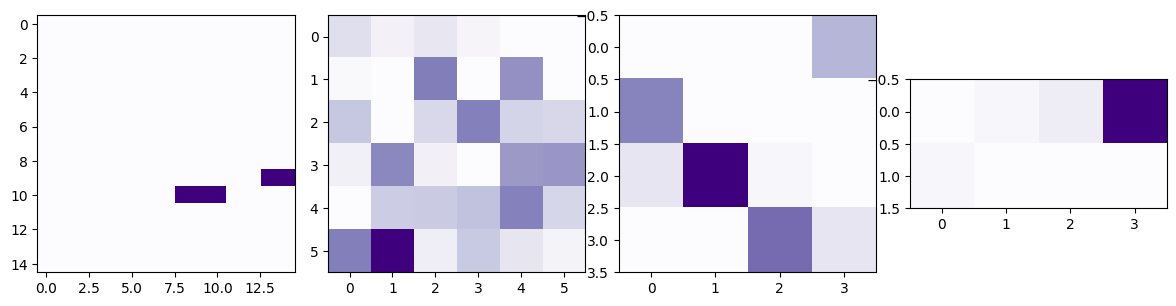

In [57]:
fig, axs = plt.subplots(1, 4, figsize=(12, 4))
axs[0].imshow(per_layer_data[0].view(15,15).detach().numpy(), cmap=cm.Purples)
axs[1].imshow(per_layer_data[1].view(6,6).detach().numpy(), cmap=cm.Purples)
axs[2].imshow(per_layer_data[2].view(4,4).detach().numpy(), cmap=cm.Purples)
axs[3].imshow(per_layer_data[3].view(2,-1).detach().numpy(), cmap=cm.Purples)

plt.tight_layout()
plt.show()

In [14]:
w = model.layers[0].weight.data
w.shape # 225 columns x 36 rows

torch.Size([36, 225])

In [44]:
x = per_layer_data[0]
print(x.unsqueeze(0).shape)
y = per_layer_data[1]
y.unsqueeze(0).T.shape # should be 36 columns and 1 row 

torch.Size([1, 225])


torch.Size([36, 1])

In [41]:
yw = y.unsqueeze(0).T * w
# this is not the same!
#yw = torch.matmul(y.unsqueeze(0).T, w)
yw.shape

torch.Size([36, 225])

In [46]:
xyw = x - yw
xyw.shape

torch.Size([36, 225])

In [47]:
dw = y.unsqueeze(0).T * xyw
dw.shape

torch.Size([36, 225])

In [55]:
model = OjasHierarchicalNetwork()

model.eta = 0.1

for i in range(K):
  activations = model(input_saccades[i])
  model.oja_update(activations)